# CGIAR Crop Yield Prediction Challenge
### Zindi Competition
### Data Science Intensive Program Final Project

#### The aim of this challenge is to create a model capable of estimating the crop-cut maize yield for fields in East Africa. Given a time-series of Sentinel 2 imagery and climate variables, the model must output a predicted yield in tons per acre.
###### Sohana Singh

### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import itertools
from pylab import rcParams
import matplotlib
from matplotlib import pyplot as plt
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
from sentinelsat import SentinelAPI
import geopandas as gpd
import folium 
import shapely
%matplotlib inline

## Data

1. Read in names of data bands and training data

In [2]:
band_names = [l.strip() for l in open('bandnames.txt', 'r').readlines()]
#print(band_names)

In [3]:
train = pd.read_csv('Train.csv')
print(train.shape)
train.head(5)

(2977, 4)


,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


The training data consists of the field id, year for which the satellite data was retrieved. The quality of the data is also indicated, with 3 being the best quality and 1 being poor quality. The crop yield is also available. The histogram of the distribution of the yield estimates indicate that the data is left-skewed, with fewer observations > 6 tons per acre. 

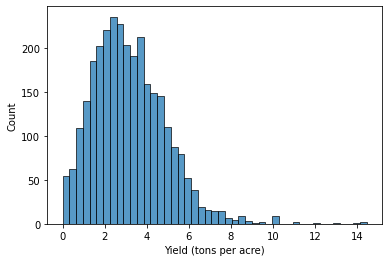

In [4]:
#Looking at the distribution of yield in the training set
ax = sns.histplot(train['Yield'], palette="mako")
ax.set(xlabel='Yield (tons per acre)', ylabel='Count')
plt.show()

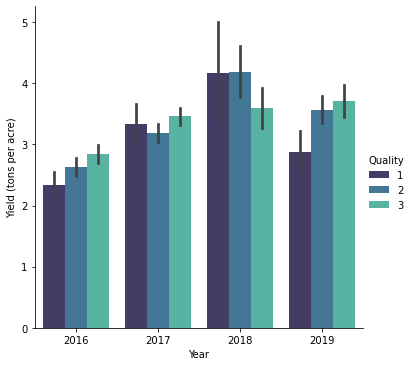

In [5]:
ax2 = sns.catplot(data=train, kind="bar", x="Year", y="Yield", hue="Quality", palette="mako")
ax2.set(xlabel='Year', ylabel='Yield (tons per acre)')

I chose to drop the data where the quality was equal to 1, as the challenge also indicated that there were no low quality fields (Quality = 1) in the test set. In some of the experiments, I also chose to drop data where yield was > 6 tons per acre.

In [6]:
train = train.drop(train[train.Quality == 1].index)
print(train.shape)
train.head(5)

(2552, 4)


,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


In [7]:
train2 = train.drop(train[train.Yield >= 6].index)
print(train2.shape)
train2.head()

(2414, 4)


,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


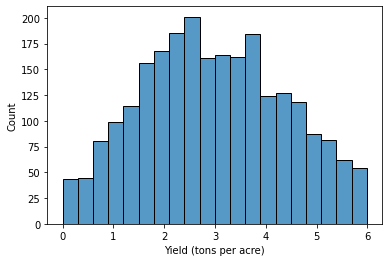

In [8]:
#Looking at the distribution of yield in the training set after outlier removal
ax3 = sns.histplot(train2['Yield'], palette="mako")
ax3.set(xlabel='Yield (tons per acre)', ylabel='Count')
plt.show()

Now the data looks more normally distributed

### Visualization of the spectral bands

Will take a look at the blue, green and red and near infrared bands for January, February and March as examples

Loading data/image_arrays_train/S5N1DP1.npy as an array
Array shape: (360, 41, 41)


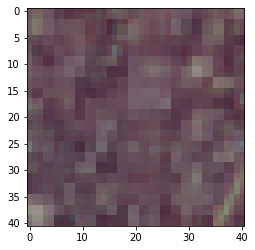

In [20]:
# Look at a sample for January
fid = train2['Field_ID'].sample().values[0]
fn = f'data/image_arrays_train/{fid}.npy' # File name based on Field_ID
print(f'Loading {fn} as an array')
arr = np.load(fn) # Loading the data with numpy
print('Array shape:', arr.shape) # 360 bands, images 40 or 41px a side
rgb_jan = np.stack([arr[4], arr[3], arr[2], arr[8]], axis=-1) # Combine three bands for viewing
rgb_jan = rgb_jan / np.max(rgb_jan) # Scale band values to (0, 1) for easy image display
plt.imshow(rgb_jan) # View with matplotlib

We can also view a histogram of the colour channels for bands 2, 3, 4, and 8 using the rasterio package.

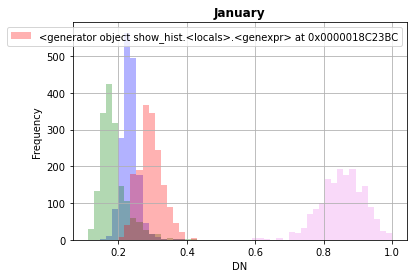

In [21]:
im2 = rio.plot.reshape_as_raster(rgb_jan)
show_hist(im2, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="January") 

Loading data/image_arrays_train/HKA73RA.npy as an array
Array shape: (360, 41, 40)


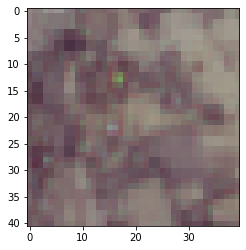

In [18]:
# February
fid = train2['Field_ID'].sample().values[0]
fn = f'data/image_arrays_train/{fid}.npy' # File name based on Field_ID
print(f'Loading {fn} as an array')
arr = np.load(fn) # Loading the data with numpy
print('Array shape:', arr.shape) # 360 bands, images 40 or 41px a side
rgb_feb = np.stack([arr[30 + 4], arr[30 + 3], arr[30 + 2], arr[30 + 8]], axis=-1) # Combine three bands for viewing
rgb_feb = rgb_feb / np.max(rgb_feb) # Scale band values to (0, 1) for easy image display
plt.imshow(rgb_feb) # View with matplotlib

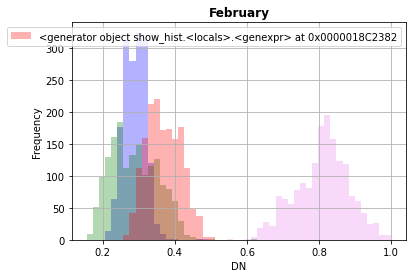

In [19]:
im3 = rio.plot.reshape_as_raster(rgb_feb)
show_hist(im3, bins =50, lw=0.0, masked = True, stacked=False, alpha=0.3, histtype='stepfilled', title="February")

Loading data/image_arrays_train/W6VIB5A.npy as an array
Array shape: (360, 41, 41)


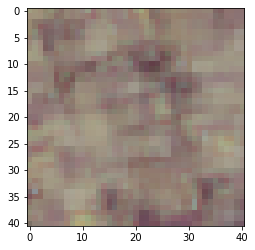

In [15]:
# March
fid = train2['Field_ID'].sample().values[0]
fn = f'data/image_arrays_train/{fid}.npy' # File name based on Field_ID
print(f'Loading {fn} as an array')
arr = np.load(fn) # Loading the data with numpy
print('Array shape:', arr.shape) # 360 bands, images 40 or 41px a side
rgb_march = np.stack([arr[30*2 + 4], arr[30*2 + 3], arr[30*2 + 2], arr[30*2 + 8]], axis=-1) # Combine three bands for viewing
rgb_march = rgb_march / np.max(rgb_march) # Scale band values to (0, 1) for easy image display
plt.imshow(rgb_march) # View with matplotlib

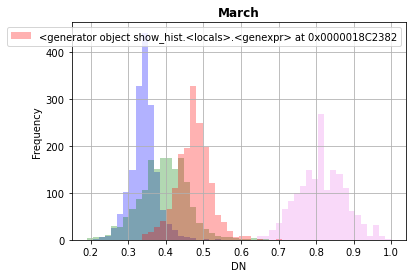

In [16]:
im4 = rio.plot.reshape_as_raster(rgb_march)
show_hist(im4, bins =50, lw=0.0, masked = True, stacked=False, alpha=0.3, histtype='stepfilled', title="March")

Let's take a look at stacked band images for each month using band 2, 3, 4 and 8 

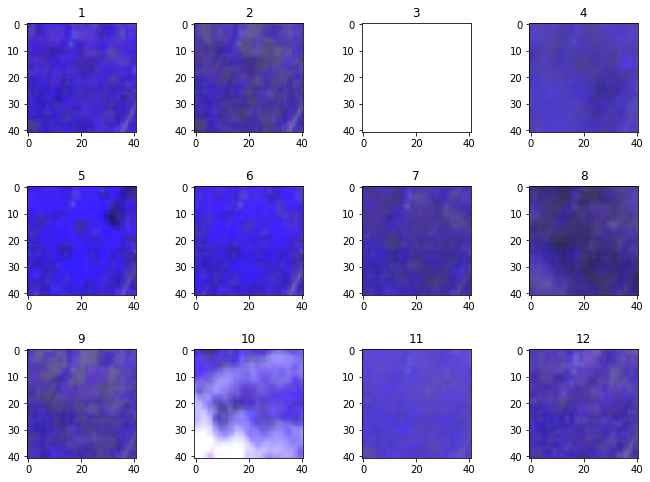

In [33]:
# View false colour images from each month in the year:
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  rgb = np.stack([arr[i*30 + 4], arr[i*30 + 3], arr[i*30 + 8]], axis=-1) # False colour (band 8, 4 and 3)
  rgb = rgb / 4000 # Scaling consistently 
  axs[i].imshow(rgb.clip(0, 1))
  axs[i].set_title(str(i+1))

### Data preprocessing

The function below will retrieve image arrays sampled at the center point for the selected bands, for all the months of the year, and it also performs the calculation of the NDVI, EVI and NDWI and adds these as features

#### Experiment 1: Using all months of the year, sampling image at centre point (20, 20), using bands B8, B5, B4, B3, B2, B12, CLIM_pr, CLIM_soil, CLIM_tmmn, CLIM_tmmx and the random forest model without hyperparameter tuning. Here we are also including the NDVI, EVI and NDWI as new features. Adding relevant features, such as these vegetation indices which are often used in yield predictions, should make the model more accurate.

In [34]:
def process_im_set1(fid, folder='data/image_arrays_train'):
  fn = f'{folder}/{fid}.npy'
  arr = np.load(fn)
  bands_of_interest = ['S2_B8','S2_B5', 'S2_B4', 'S2_B3', 'S2_B2', 'S2_B12' 'CLIM_pr', 'CLIM_soil', 'CLIM_tmmn', 'CLIM_tmmx']
  #bands_of_interest = ['S2_B2', 'S2_B3', 'S2_B4', 'S2_B5', 'S2_B6', 'S2_B7', 'S2_B8', 'S2_B8A', 'CLIM_pdsi',
                      #'CLIM_pr', 'CLIM_soil', 'CLIM_tmmn', 'CLIM_tmmx']
  #bands_of_interest = ['S2_B2', 'S2_B3', 'S2_B4', 'S2_B5', 'CLIM_pr', 'CLIM_soil', 'CLIM_tmmn', 'CLIM_tmmx']

  values = {}
  for month in range(12):
    bns = [str(month) + '_' + b for b in bands_of_interest] # Bands of interest for this month 
    idxs = np.where(np.isin(band_names, bns)) # Index of these bands
    vs = arr[idxs, 20, 20] # Sample the im at the center point
    nir = np.int64(vs[0][0])
    red = np.int64(vs[0][2])
    blue = np.int64(vs[0][4])
    SWIR = np.int64(vs[0][5])
    ndvi = (nir - red) / (nir + red)
    evi = (2.5 * (nir - red)) / ((nir + 6.0 * red - 7.5 * blue) + 1.0)
    ndwi = (nir - SWIR) / (nir + SWIR)
    
    for bn, v in zip(bns, vs[0]):
      values[bn] = v
    values[str(month) + '_ndvi'] = ndvi
    values[str(month) + '_evi'] = evi
    values[str(month) + '_ndwi'] = ndwi
  return values

In [35]:
# Make a new DF with the sampled values from each field 
train_sampled_set1 = pd.DataFrame([process_im_set1(fid) for fid in train2['Field_ID'].values])

# Add in the field ID and yield
train_sampled_set1['Field_ID'] = train2['Field_ID'].values
train_sampled_set1['Yield'] = train2['Yield'].values
train_sampled_set1['Year'] = train2['Year'].values
train_sampled_set1.head()

,0_S2_B8,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_S2_B12CLIM_pr,0_CLIM_soil,0_CLIM_tmmn,0_ndvi,0_evi,...,11_S2_B2,11_S2_B12CLIM_pr,11_CLIM_soil,11_CLIM_tmmn,11_ndvi,11_evi,11_ndwi,Field_ID,Yield,Year
0,934,932,1173,1392,2038,287,112,285,-0.113431,0.081715,...,1845,215,100,267,0.308707,-0.081746,0.551616,MH2O0YH,3.686,2019
1,880,821,924,1116,1951,287,108,288,-0.024390,0.013402,...,891,215,99,273,0.370370,-0.235119,0.531590,O9TURWL,5.657,2019
2,1016,1070,1357,1632,2137,278,109,288,-0.143700,0.124117,...,4173,289,100,274,-0.101485,0.244704,0.820720,35AFSDD,3.082,2019
3,777,784,639,1064,2588,299,110,282,0.097458,-0.023314,...,8648,189,98,263,-0.048061,0.195329,0.949452,PM05EG9,2.707,2019
4,1081,1122,1162,1487,2603,427,161,320,-0.036112,0.017657,...,3455,1214,143,291,0.143787,-0.032922,-0.070547,V7PZBCG,2.679,2019


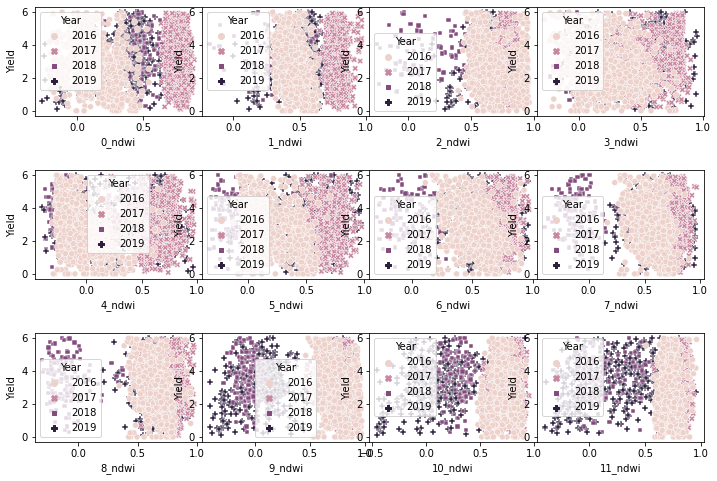

In [39]:
ndfig, ndaxs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
ndfig.subplots_adjust(hspace = .5, wspace=.001)
for month in range(12):
    col_name = str(month) + '_ndwi'
    ax_row = int(month / 4)
    ax_col = int(month % 4)
    sns.scatterplot(ax=ndaxs[ax_row, ax_col], data=train_sampled_set1, x= col_name, y= "Yield" , hue = "Year", style = "Year")

In [41]:
train_sampled_set1.describe()

,0_S2_B8,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_S2_B12CLIM_pr,0_CLIM_soil,0_CLIM_tmmn,0_ndvi,0_evi,...,11_S2_B3,11_S2_B2,11_S2_B12CLIM_pr,11_CLIM_soil,11_CLIM_tmmn,11_ndvi,11_evi,11_ndwi,Yield,Year
count,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,...,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000
mean,964.614747,996.826015,1060.983016,1367.659486,2497.625518,411.782104,140.592792,304.060895,-0.029367,0.034766,...,1462.688484,2776.067109,332.421707,140.779205,296.282519,0.019779,-0.000296,0.634505,2.979303,2017.065037
std,119.131516,148.995744,308.588928,262.113195,379.672247,297.571714,19.013145,11.779858,0.106502,0.062883,...,735.952965,765.999735,417.420089,19.635081,10.295657,0.100357,0.065910,0.294344,1.401574,1.056778
min,676.000000,512.000000,326.000000,389.000000,837.000000,75.000000,89.000000,244.000000,-0.289295,-0.240088,...,303.000000,490.000000,38.000000,80.000000,236.000000,-0.219068,-0.769877,-0.400654,0.000000,2016.000000
25%,886.000000,897.000000,820.000000,1181.000000,2251.000000,139.250000,127.000000,298.000000,-0.117168,-0.016608,...,1163.000000,2388.000000,90.000000,126.000000,291.000000,-0.052132,-0.026552,0.628481,1.943813,2016.000000
50%,947.500000,973.000000,1040.000000,1335.000000,2491.000000,361.500000,142.000000,304.000000,-0.038239,0.017383,...,1302.000000,2682.500000,142.000000,143.000000,299.000000,0.013625,-0.005271,0.749108,2.914000,2017.000000
75%,1023.750000,1070.000000,1267.750000,1526.750000,2744.750000,622.000000,155.000000,315.000000,0.052238,0.075398,...,1496.000000,3015.750000,227.000000,158.000000,304.000000,0.085470,0.026050,0.823521,4.017062,2017.000000
max,2859.000000,2890.000000,2983.000000,3374.000000,4441.000000,1338.000000,176.000000,326.000000,0.349301,0.323518,...,8962.000000,9249.000000,2143.000000,177.000000,313.000000,0.419766,0.375723,0.958883,5.990000,2019.000000


We will also apply the function to the test dataset

In [43]:
ss = pd.read_csv('SampleSubmission.csv')
test_sampled_set1 = pd.DataFrame([process_im_set1(fid, folder='data/image_arrays_test') for fid in ss['Field_ID'].values])
test_sampled_set1.head()
test_cols = list(test_sampled_set1.columns)
print(test_cols)

['0_S2_B8', '0_S2_B5', '0_S2_B4', '0_S2_B3', '0_S2_B2', '0_S2_B12CLIM_pr', '0_CLIM_soil', '0_CLIM_tmmn', '0_ndvi', '0_evi', '0_ndwi', '1_S2_B8', '1_S2_B5', '1_S2_B4', '1_S2_B3', '1_S2_B2', '1_S2_B12CLIM_pr', '1_CLIM_soil', '1_CLIM_tmmn', '1_ndvi', '1_evi', '1_ndwi', '2_S2_B8', '2_S2_B5', '2_S2_B4', '2_S2_B3', '2_S2_B2', '2_S2_B12CLIM_pr', '2_CLIM_soil', '2_CLIM_tmmn', '2_ndvi', '2_evi', '2_ndwi', '3_S2_B8', '3_S2_B5', '3_S2_B4', '3_S2_B3', '3_S2_B2', '3_S2_B12CLIM_pr', '3_CLIM_soil', '3_CLIM_tmmn', '3_ndvi', '3_evi', '3_ndwi', '4_S2_B8', '4_S2_B5', '4_S2_B4', '4_S2_B3', '4_S2_B2', '4_S2_B12CLIM_pr', '4_CLIM_soil', '4_CLIM_tmmn', '4_ndvi', '4_evi', '4_ndwi', '5_S2_B8', '5_S2_B5', '5_S2_B4', '5_S2_B3', '5_S2_B2', '5_S2_B12CLIM_pr', '5_CLIM_soil', '5_CLIM_tmmn', '5_ndvi', '5_evi', '5_ndwi', '6_S2_B8', '6_S2_B5', '6_S2_B4', '6_S2_B3', '6_S2_B2', '6_S2_B12CLIM_pr', '6_CLIM_soil', '6_CLIM_tmmn', '6_ndvi', '6_evi', '6_ndwi', '7_S2_B8', '7_S2_B5', '7_S2_B4', '7_S2_B3', '7_S2_B2', '7_S2_B12CLIM

The next step is to scale the data. I will use the minmaxscaler from scikit-learn

In [44]:
X, y  = train_sampled_set1[train_sampled_set1.columns[:-3]], train_sampled_set1['Yield']
cols = list(X.columns)
#print(cols)
mm_scaler = preprocessing.MinMaxScaler()
X = mm_scaler.fit_transform(X)
X = pd.DataFrame(X)
X.columns = cols
X.head()

,0_S2_B8,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_S2_B12CLIM_pr,0_CLIM_soil,0_CLIM_tmmn,0_ndvi,0_evi,...,11_S2_B5,11_S2_B4,11_S2_B3,11_S2_B2,11_S2_B12CLIM_pr,11_CLIM_soil,11_CLIM_tmmn,11_ndvi,11_evi,11_ndwi
0,0.118186,0.176619,0.318781,0.336013,0.333241,0.167854,0.264368,0.500000,0.275391,0.570972,...,0.032287,0.014179,0.056242,0.154698,0.084086,0.206186,0.402597,0.826154,0.600673,0.700437
1,0.093449,0.129941,0.225066,0.243551,0.309101,0.167854,0.218391,0.536585,0.414824,0.449765,...,0.009504,0.005908,0.013512,0.045781,0.084086,0.195876,0.480519,0.922678,0.466793,0.685707
2,0.155749,0.234651,0.388032,0.416415,0.360710,0.160728,0.229885,0.536585,0.227993,0.646206,...,0.326780,0.392887,0.443700,0.420482,0.119240,0.206186,0.493506,0.184060,0.885633,0.898375
3,0.046267,0.114382,0.117802,0.226131,0.485849,0.177356,0.241379,0.463415,0.605629,0.384620,...,0.903268,0.915987,0.895484,0.931385,0.071734,0.185567,0.350649,0.267687,0.842534,0.993063
4,0.185525,0.256518,0.314641,0.367839,0.490011,0.278702,0.827586,0.926829,0.396468,0.457314,...,0.084104,0.060971,0.120799,0.338509,0.558670,0.649485,0.714286,0.567996,0.643292,0.242808


Do the same for the test data

In [45]:
mm_scaler = preprocessing.MinMaxScaler()
test_sampled_mm = mm_scaler.fit_transform(test_sampled_set1)
test_sampled_mm= pd.DataFrame(test_sampled_mm)
test_sampled_mm.columns = test_cols
test_sampled_mm.head()

,0_S2_B8,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_S2_B12CLIM_pr,0_CLIM_soil,0_CLIM_tmmn,0_ndvi,0_evi,...,11_S2_B5,11_S2_B4,11_S2_B3,11_S2_B2,11_S2_B12CLIM_pr,11_CLIM_soil,11_CLIM_tmmn,11_ndvi,11_evi,11_ndwi
0,0.040259,0.065249,0.055865,0.108915,0.292888,0.229374,0.756410,0.840000,0.558305,0.360404,...,0.089308,0.073354,0.134615,0.308514,0.456113,0.677419,0.647059,0.576232,0.584118,0.381446
1,0.037173,0.056769,0.045098,0.092813,0.296281,0.229374,0.756410,0.840000,0.634772,0.349349,...,0.075520,0.060262,0.118213,0.341235,0.456113,0.677419,0.647059,0.640389,0.579550,0.371627
2,0.047017,0.069848,0.078541,0.115067,0.214848,0.220308,0.794872,0.853333,0.426370,0.386325,...,0.074035,0.053331,0.104638,0.323706,0.428683,0.725806,0.661765,0.679002,0.569018,0.390745
3,0.040699,0.071716,0.042057,0.100929,0.364007,0.220308,0.794872,0.853333,0.685286,0.349033,...,0.122189,0.080863,0.142911,0.424374,0.428683,0.725806,0.661765,0.596555,0.593909,0.436391
4,0.050103,0.073872,0.127059,0.133656,0.180375,0.220308,0.794872,0.853333,0.164679,0.561675,...,0.084429,0.049673,0.109163,0.428214,0.428683,0.725806,0.661765,0.707808,0.584858,0.392103


In [46]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y)

Score: 1.2928282918782719


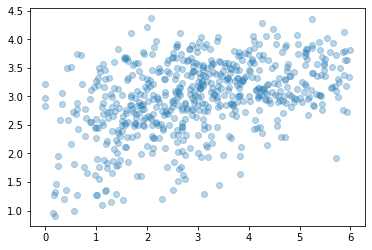

In [47]:
# Fit the model
RFmodel_exp1 = RandomForestRegressor(random_state = 33)
RFmodel_exp1.fit(X_train, y_train)

# Score with RMSE
print('Score:', mean_squared_error(y_test, RFmodel_exp1.predict(X_test), squared=False))

# Plot pred vs actual for the test set:
plt.scatter(y_test, RFmodel_exp1.predict(X_test), alpha=0.3)

In [48]:
# Get model predictions
preds = RFmodel_exp1.predict(test_sampled_mm)

# Store them in the submission dataframe and save
ss['Yield'] = preds
ss.to_csv('SUBRF_EXP1.csv', index=False)
ss.head()

,Field_ID,Yield
0,E9UZCEA,3.177685
1,1WGGS1Q,3.002755
2,EG2KXE2,3.350412
3,HC3GQXF,2.870570
4,7AK6GFK,3.006283


This model achieved a score of 1.73636207558991 on Zindi. It is an improvement on the score of 1.80 obtained with just the starter notebook provided which had no additional features, and no removal of outliers or application of a scaler. I am confident that optimizing the various parameters by hyperparameter tuning will improve the model and the overall score.

#### Experiment 2: Using the Set 1 data but performing hyperparameter tuning on the RF model in order to improve the predictions and the score. RandomizedSearch CV was used to perform hyperparameter tuning. Parameters that will be optimized are the number of estimators, the maximum number of features, maximum depth, minimum samples split and minimum samples per leaf.

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)
# {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000]}

In [ ]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train, y_train)

In [ ]:
# #taking a look at the optimal parameters
# rf_random.best_params_

Score: 1.2848991300603299


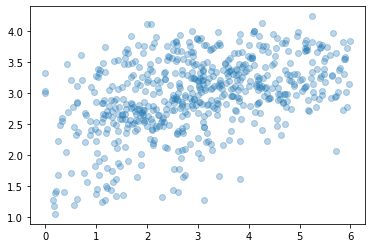

In [49]:
# Fit the model
RFmodel_Exp2 = RandomForestRegressor(random_state = 33, n_estimators = 555, min_samples_split=10,
                                     min_samples_leaf=2, max_features='sqrt', max_depth = 10, bootstrap=True)
RFmodel_Exp2.fit(X_train, y_train)

# Score with RMSE
print('Score:', mean_squared_error(y_test, RFmodel_Exp2.predict(X_test), squared=False))

# Plot pred vs actual for the test set:
plt.scatter(y_test, RFmodel_Exp2.predict(X_test), alpha=0.3)

In [50]:
# Get model predictions
preds = RFmodel_Exp2.predict(test_sampled_mm)

# Store them in the submission dataframe and save
ss['Yield'] = preds
ss.to_csv('SUBRF_EXP2.csv', index=False)
ss.head()

,Field_ID,Yield
0,E9UZCEA,3.167346
1,1WGGS1Q,3.184751
2,EG2KXE2,3.137179
3,HC3GQXF,2.973814
4,7AK6GFK,2.918802


Zindi Score: 1.71101788033305. Here there is already an improvement just by performing hyperparameter tuning. The next step would be to investigate other algorithms such as XGBoost, to see if the score and the predictions can be improved.


#### Experiment 3:
Next, I will take it up a notch by using the same dataset to evalaute the XGBoost Regressor. The Zindi challenge requires that the solution to the problem be lightweight, and it must be able to run on a single GPU machine with less than 8 hours training and two hours inference. The XGBoost algorithm utilizes gradient boosting optimization techniques to yield superior results using less computing resources in the shortest amount of time.

In [51]:
xg_reg_t = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.01,
                max_depth = 3, min_child_weight = 5, subsample = 0.5, alpha = 10, n_estimators = 500)

Score: 1.2921810917009873


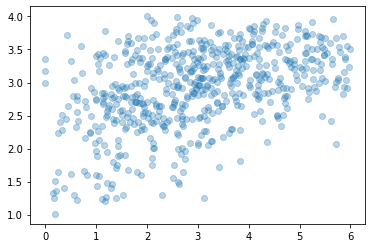

In [52]:
xg_reg_t.fit(X_train, y_train)
# Score with RMSE
print('Score:', mean_squared_error(y_test, xg_reg_t.predict(X_test), squared=False))

# Plot pred vs actual for the test set:
plt.scatter(y_test, xg_reg_t.predict(X_test), alpha=0.3)

In [54]:
# Get model predictions
preds = xg_reg_t.predict(test_sampled_mm)

# Store them in the submission dataframe and save
ss['Yield'] = preds
ss.to_csv('XGB_Exp3.csv', index=False)
ss.head()

,Field_ID,Yield
0,E9UZCEA,2.695384
1,1WGGS1Q,2.950871
2,EG2KXE2,2.827220
3,HC3GQXF,2.576436
4,7AK6GFK,2.622611


Zindi Score: 1.781074957852. Although this score was quite worse than that obtained using the Random Forest Regressor, I predict that tuning the hyperparameters of the XGBoost model might improve the score and predictions


In [ ]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = xgb.XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)
    return gsearch.best_params_

In [ ]:
hyperParameterTuning(X_train, y_train)

In [55]:
xg_reg_t2 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.7, learning_rate = 0.01,
                max_depth = 3, min_child_weight = 5, subsample = 0.7, n_estimators = 500)

Score: 1.283792919915665


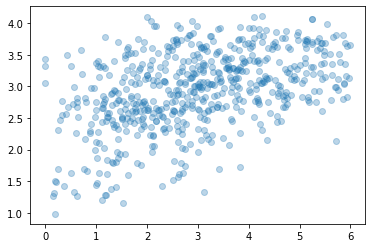

In [56]:
xg_reg_t2.fit(X_train, y_train)
# Score with RMSE
print('Score:', mean_squared_error(y_test, xg_reg_t2.predict(X_test), squared=False))

# Plot pred vs actual for the test set:
plt.scatter(y_test, xg_reg_t2.predict(X_test), alpha=0.3)

In [57]:
# Get model predictions
preds = xg_reg_t2.predict(test_sampled_mm)

# Store them in the submission dataframe and save
ss['Yield'] = preds
ss.to_csv('Subxgb_tuned01.csv', index=False)
ss.head()
###Best score so far

,Field_ID,Yield
0,E9UZCEA,3.156812
1,1WGGS1Q,3.185063
2,EG2KXE2,3.056031
3,HC3GQXF,2.889839
4,7AK6GFK,2.942765


Zindi score: 1.68671523385577. Even though I have tried mutliple other ways to improve this score, such as experimenting with including different bands, expanding the image field sampled and only considering the months of the year just before the harvest (Please see separate notebook for these), I could not improve upon this score as of 26 January 2021. XGBoost is likely not the best solution for the problem, and looking into neural networks might be beneficial. Additional features could also be added to the dataset, and other methods of scaling the data could also be investigated. The competition ends in February, and I would like to make more attempts until then. 